In [1]:
import gensim
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as sps
import pickle
import yfinance as yf
import statsmodels.api as sm
import math

from tqdm import tqdm
from gensim.models import KeyedVectors
from datetime import datetime

sns.set_style("whitegrid")

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
df_test = pd.read_pickle("/content/drive/MyDrive/ML_EPFL_Project/data/test.pkl")
snp500 = pd.read_csv("/content/drive/MyDrive/ML_EPFL_Project/data/market.csv")
stocks = pd.read_csv('/content/drive/MyDrive/ML_EPFL_Project/data/stocks.csv')
stocks.loc[:, 'Date'] = pd.to_datetime(stocks['Date'], format='%Y-%m-%d')
snp500['Date'] = snp500['Date'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d")).astype(object)

df_test.head()

,date,exchange,q,ticker,transcript,daily_r,weekly_r,monthly_r
5748,2021-07-27 00:00:00,NASDAQ: FELE,2021-Q2,FELE,prepared remark operator good morning lady gen...,-0.006114,0.005258,0.020543
2743,2019-07-02 00:00:00,NYSE: GBX,2019-Q3,GBX,prepared remark operator hello welcome greenbr...,0.027027,0.033514,-0.141622
16479,2022-05-06 00:00:00,NYSE: GTN,2022-Q1,GTN,prepared remark operator good day thank standi...,-0.068500,0.005000,-0.088000
15556,2021-08-05 00:00:00,NASDAQ: DDOG,2021-Q2,DDOG,prepared remark operator welcome q2 2021 datad...,-0.013826,0.029398,0.100957
3413,2021-01-19 00:00:00,NYSE: BAC,2020-Q4,BAC,prepared remark operator good day everyone wel...,0.008000,-0.064000,0.106769


In [7]:
index = stocks[['Date']]

In [8]:
def add_trade(cur_row, strategy, holding_period):
    start_dt = cur_row['date']
    ticker = cur_row['ticker']
    coef = cur_row['alpha']
    msk = (index['Date'] >= start_dt)

    for i in range(0, holding_period):
        cur_date = index[msk]['Date'].iloc[i]
        if coef > 0:
            strategy.loc[cur_date, 'long'][ticker] = coef

        elif coef < 0:
            strategy.loc[cur_date, 'short'][ticker] = -coef


def get_weights(cur_day):
    coefs_l = cur_day['long']
    coefs_s = cur_day['short']

    if len(coefs_l) + len(coefs_s) == 0:
        return pd.Series({"weight": {}})

    companies = [x for x in coefs_l] + [x for x in coefs_s]
    alpha_pos = sum([coefs_l[x] for x in coefs_l])
    alpha_neg = sum([coefs_s[x] for x in coefs_s])
    ss = alpha_pos + alpha_neg

    coefs = {}

    for tick in coefs_l:
        coefs[tick] =  coefs_l[tick] / ss

    for tick in coefs_s:
        coefs[tick] =  -coefs_s[tick] / ss

    return pd.Series({"weight": coefs})


def run_strategy(X_0, strategy):
    portfolio_value = [X_0]
    num_stocks = []
    change_stocks = []
    added_value = []
    delta = []
    returns = []

    t = 0

    for t in tqdm(range(0, strategy.shape[0])):
        cur_r = strategy.iloc[t]
        X_cur = portfolio_value[-1]
        cur_c = cur_r['weight']

        if len(cur_c) == 0:
            portfolio_value.append(X_cur)
            num_stocks.append({})
            change_stocks.append({})
            added_value.append({})
            delta.append(0)
            returns.append(0)

            continue

        cur_st_pr = stocks[stocks['Date'] == cur_r.name]
        cur_w = {x: int(cur_c[x] * X_cur / cur_st_pr[x].item())  for x in cur_c}
        value = sum([abs(cur_w[st]) * cur_st_pr[st].item() for st in cur_c])

        if value > X_cur:
          print("\nError", t)
          print("Value:", value, "X_cur:",  X_cur, "Delta:", X_cur - value)
          print("----------")

        next_st_pr = stocks[stocks['Date'] == strategy.iloc[t+1].name]
        delta_W = sum([cur_w[st] * (next_st_pr[st].item() - cur_st_pr[st].item()) for st in cur_c])

        portfolio_value.append(X_cur + delta_W)
        num_stocks.append(cur_w)
        change_stocks.append({st: next_st_pr[st].item() - cur_st_pr[st].item() for st in cur_c})
        added_value.append({st: cur_w[st] * (next_st_pr[st].item() - cur_st_pr[st].item()) for st in cur_c})
        delta.append(delta_W)
        returns.append(delta_W / X_cur)


    pnl = pd.DataFrame({
      "date": index['Date'],
      "value": portfolio_value[:-1],
      "number_stocks": num_stocks,
      "change_stock": change_stocks,
      "added_value": added_value,
      "delta": delta,
      "return": returns,
    })

    while pnl.iloc[0].value == pnl.iloc[1].value and pnl.iloc[1].value == pnl.iloc[2].value:
        pnl = pnl.iloc[1:]

    while pnl.iloc[-1].value == pnl.iloc[-2].value and pnl.iloc[-3].value == pnl.iloc[-2].value:
        pnl = pnl.iloc[:-1]

    return pnl


In [28]:
def get_coefs(path):
    coefs = pd.read_csv(path)
    coefs.set_index('Unnamed: 0', inplace=True)
    coefs.rename(columns={coefs.columns[0]: 'alpha'}, inplace=True)

    return coefs


def descr(df):
    st = df.describe()
    for col in st.index.difference(["count"]):
        st.loc[col] = st.loc[col].apply(lambda x: "{0:.2%}".format(x))

    return st


def get_precision(path):
    coefs = pd.read_csv(path)
    coefs.set_index('Unnamed: 0', inplace=True)
    coefs.rename(columns={coefs.columns[0]: 'alpha'}, inplace=True)

    df_strategy = df_test.merge(coefs, how='left', left_index=True, right_index=True)
    df_strategy['trd'] = df_strategy['weekly_r'].apply(lambda x: np.abs(x) > 0.04)
    need_to_trade = df_strategy['trd'].sum()
    actual_trade = sum(df_strategy[df_strategy.trd == True].alpha != 0)
    recall = actual_trade / need_to_trade


    df_strategy['trade'] = df_strategy['alpha'] != 0
    df_strategy['match'] = (df_strategy['alpha'] * df_strategy['weekly_r']) > 0

    traded = df_strategy[df_strategy['trade'] == True]
    precision = traded['match'].sum() / traded['trade'].sum()

    return precision, recall


def get_alpha_stats(pnl_res, title, path):
    df = pd.merge(pnl_res, snp500, left_on='date', right_on='Date')

    rf_annual = 0.04
    rf_daily = (1 + rf_annual) ** (1 / 252) - 1

    x = df['ret_mar'] - rf_daily
    rets = df[['Date', 'return']].copy()
    rets.set_index('Date', inplace=True)
    w_rets = (1 + rets).resample('W').prod() - 1
    y_rets = (1 + rets).resample('Y').prod() - 1

    y = df['return'] - rf_daily

    X2 = sm.add_constant(x)
    est = sm.OLS(y, X2)
    est_res = est.fit()
    precision, recall = get_precision(path)

    stats = {
        'title': [title],
        'precision': [precision],
        'recall': [recall],
        'weekly mean': [w_rets.mean().item()],
        'weekly std': [w_rets.std().item()],
        'yearly mean': [y_rets.mean().item()],
        'yearly std': [y_rets.std().item()],
        'SR': [(y_rets.mean().item() - rf_annual) / y_rets.std().item()],
        'alpha': [est_res.params['const']],
        't(alpha)': [est_res.tvalues['const']],
        'beta': [est_res.params['ret_mar']],
        't(beta)': [est_res.tvalues['ret_mar']],
        'F-statistic': [est_res.fvalue],
        'R-squared': [est_res.rsquared],
        # 'AIC': [est_res.aic],
    }
    # 'precision',

    res = pd.DataFrame(stats)
    for col in ['precision', 'recall', 'weekly mean', 'weekly std', 'yearly mean', 'yearly std',
                'alpha', 'R-squared']:
        res[col] = res[col].apply(lambda x: "{0:.2%}".format(x))

    for col in ['t(alpha)', 'SR', 'beta', 't(beta)', 'F-statistic']:
        res[col] = res[col].apply(lambda x: "{0:.2f}".format(x))


    return res

In [29]:
n = 1289
k = 2

In [30]:
import scipy.stats as sps

sps.t(df=n-k).isf(0.05), sps.f(k-1, n-k).isf(0.05)

(1.646038454643832, 3.8486943420038298)

In [31]:
def combine_signals(row, colnames):
    cx = colnames[0]
    cy = colnames[1]

    if row[cx] * row[cy] > 0:
        return row[cx] / abs(row[cx])
    return 0


def merge_coefs(path1, path2):
    c0 = get_coefs(path1)
    c1 = get_coefs(path2)
    merged = pd.merge(c0, c1, left_index=True, right_index=True)
    cols = merged.columns
    merged['alpha'] = merged.apply(combine_signals, args=(cols,), axis=1)
    merged.drop(columns=cols, inplace=True)
    return merged


In [32]:
def get_strtategy(path, holding_pediod=7):
    coefs = pd.read_csv(path) #df_test.daily_r.apply(get_coef)
    coefs.set_index('Unnamed: 0', inplace=True)
    coefs.rename(columns={coefs.columns[0]: 'alpha'}, inplace=True)
    coefs.head()

    strategy = pd.DataFrame({
        "long": {date: {} for date in index.Date},
        "short": {date: {} for date in index.Date},
    })

    df_strategy = df_test[['date', 'ticker']].merge(coefs, how='left', left_index=True, right_index=True)
    df_strategy.apply(add_trade, axis=1, args=(strategy, holding_pediod,))
    strategy = strategy.apply(get_weights, axis=1)
    return strategy


In [33]:
def get_strategy_results(path, title, X_0 = 10000):
    strategy = get_strtategy(path)
    pnl = run_strategy(X_0, strategy)
    res = get_alpha_stats(pnl, title, path)
    res.to_csv('/content/drive/MyDrive/ML_EPFL_Project/Strategies_stats/' + path.split('/')[-1])

    return pnl, res


In [54]:
total_stats = []

In [55]:
path = '/content/drive/MyDrive/ML_EPFL_Project/Strategies_coefs/multinomial_naive_bayes.csv'

pnl_v0, res_v0 = get_strategy_results(path, 'Naive Bayes')
total_stats.append(res_v0)
res_v0

100%|██████████| 1509/1509 [00:04<00:00, 357.78it/s]


,title,precision,recall,weekly mean,weekly std,yearly mean,yearly std,SR,alpha,t(alpha),beta,t(beta),F-statistic,R-squared
0,Naive Bayes,44.52%,64.74%,-0.49%,4.34%,-19.56%,25.74%,-0.92,-0.12%,-1.94,0.18,4.02,16.18,1.24%


In [56]:
path = '/content/drive/MyDrive/ML_EPFL_Project/Strategies_coefs/rnn_v1.csv'

pnl_v1, res_v1 = get_strategy_results(path, 'RNN imbalanced classes')
total_stats.append(res_v1)
res_v1

100%|██████████| 1509/1509 [00:04<00:00, 333.46it/s]


,title,precision,recall,weekly mean,weekly std,yearly mean,yearly std,SR,alpha,t(alpha),beta,t(beta),F-statistic,R-squared
0,RNN imbalanced classes,53.66%,73.68%,0.31%,4.38%,12.13%,25.95%,0.31,0.06%,0.88,-0.05,-0.99,0.98,0.08%


In [57]:
path = '/content/drive/MyDrive/ML_EPFL_Project/Strategies_coefs/rnn_v3.csv'

pnl_v2, res_v2 = get_strategy_results(path, 'RNN 3 classes')
total_stats.append(res_v2)
res_v2

100%|██████████| 1509/1509 [00:04<00:00, 326.51it/s]


,title,precision,recall,weekly mean,weekly std,yearly mean,yearly std,SR,alpha,t(alpha),beta,t(beta),F-statistic,R-squared
0,RNN 3 classes,53.47%,59.76%,0.23%,5.31%,6.57%,25.35%,0.10,0.04%,0.56,-0.19,-3.67,13.47,1.04%


In [58]:
path = '/content/drive/MyDrive/ML_EPFL_Project/Strategies_coefs/attention_v1.csv'

pnl_v3, res_v3 = get_strategy_results(path, 'RNN with attention')
total_stats.append(res_v3)
res_v3

100%|██████████| 1509/1509 [00:05<00:00, 251.63it/s]


,title,precision,recall,weekly mean,weekly std,yearly mean,yearly std,SR,alpha,t(alpha),beta,t(beta),F-statistic,R-squared
0,RNN with attention,51.55%,62.46%,0.32%,4.65%,12.58%,31.83%,0.27,0.06%,1.05,-0.33,-7.29,53.13,3.85%


In [59]:
path = '/content/drive/MyDrive/ML_EPFL_Project/Strategies_coefs/bert.csv'

pnl_v4, res_v4 = get_strategy_results(path, 'FinBert')
total_stats.append(res_v4)
res_v4

100%|██████████| 1509/1509 [00:01<00:00, 1232.31it/s]


,title,precision,recall,weekly mean,weekly std,yearly mean,yearly std,SR,alpha,t(alpha),beta,t(beta),F-statistic,R-squared
0,FinBert,58.93%,6.57%,0.62%,5.82%,32.16%,65.91%,0.43,0.11%,1.42,0.14,2.42,5.87,0.54%


In [60]:
path = '/content/drive/MyDrive/ML_EPFL_Project/Strategies_coefs/xgboosted_optimized_20features_nb.csv'

pnl_v5, res_v5 = get_strategy_results(path, 'XGBoost 20 features')
total_stats.append(res_v5)
res_v5

100%|██████████| 1509/1509 [00:04<00:00, 334.18it/s]


,title,precision,recall,weekly mean,weekly std,yearly mean,yearly std,SR,alpha,t(alpha),beta,t(beta),F-statistic,R-squared
0,XGBoost 20 features,52.67%,68.35%,0.43%,4.64%,19.52%,39.99%,0.39,0.08%,1.38,-0.23,-5.19,26.93,1.99%


In [61]:
path = '/content/drive/MyDrive/ML_EPFL_Project/Strategies_coefs/catboosted_100features_nb.csv'

pnl_v6, res_v6 = get_strategy_results(path, 'Catboost 100 features')
total_stats.append(res_v6)
res_v6

100%|██████████| 1509/1509 [00:04<00:00, 304.31it/s]


,title,precision,recall,weekly mean,weekly std,yearly mean,yearly std,SR,alpha,t(alpha),beta,t(beta),F-statistic,R-squared
0,Catboost 100 features,55.30%,68.67%,0.88%,5.18%,43.11%,60.73%,0.64,0.17%,2.82,-0.22,-4.98,24.83,1.85%


In [62]:
merged_v0 = merge_coefs(
     '/content/drive/MyDrive/ML_EPFL_Project/Strategies_coefs/catboosted_100features_nb.csv',
    '/content/drive/MyDrive/ML_EPFL_Project/Strategies_coefs/xgboosted_basic_nb.csv'
)
merged_v0.to_csv('/content/drive/MyDrive/ML_EPFL_Project/Strategies_coefs/merged_v0.csv')

In [63]:
path = '/content/drive/MyDrive/ML_EPFL_Project/Strategies_coefs/merged_v0.csv'

pnl_v7, res_v7 = get_strategy_results(path, 'Catboost + XGBoost')
total_stats.append(res_v7)
res_v7

100%|██████████| 1509/1509 [00:03<00:00, 389.61it/s]


,title,precision,recall,weekly mean,weekly std,yearly mean,yearly std,SR,alpha,t(alpha),beta,t(beta),F-statistic,R-squared
0,Catboost + XGBoost,56.37%,32.40%,0.89%,5.75%,40.91%,53.70%,0.69,0.18%,2.43,-0.23,-4.29,18.43,1.38%


In [64]:
merged_v1 = merge_coefs(
    '/content/drive/MyDrive/ML_EPFL_Project/Strategies_coefs/rnn_v1.csv',
    '/content/drive/MyDrive/ML_EPFL_Project/Strategies_coefs/attention_v1.csv'
)
merged_v1.to_csv('/content/drive/MyDrive/ML_EPFL_Project/Strategies_coefs/merged_v1.csv')

In [65]:
path = '/content/drive/MyDrive/ML_EPFL_Project/Strategies_coefs/merged_v1.csv'

pnl_v8, res_v8 = get_strategy_results(path, 'RNN + Attention')
total_stats.append(res_v8)
res_v8

100%|██████████| 1509/1509 [00:02<00:00, 702.14it/s]


,title,precision,recall,weekly mean,weekly std,yearly mean,yearly std,SR,alpha,t(alpha),beta,t(beta),F-statistic,R-squared
0,RNN + Attention,56.73%,23.58%,0.67%,6.05%,27.97%,33.75%,0.71,0.13%,1.67,-0.32,-5.48,30.05,2.28%


In [66]:
merged_v2 = merge_coefs(
    '/content/drive/MyDrive/ML_EPFL_Project/Strategies_coefs/catboosted_100features_nb.csv',
    '/content/drive/MyDrive/ML_EPFL_Project/Strategies_coefs/attention_v1.csv'
)
merged_v2.to_csv('/content/drive/MyDrive/ML_EPFL_Project/Strategies_coefs/merged_v2.csv')

In [67]:
path = '/content/drive/MyDrive/ML_EPFL_Project/Strategies_coefs/merged_v2.csv'

pnl_v9, res_v9 = get_strategy_results(path, 'Catboost + Attention')
total_stats.append(res_v9)
res_v9

100%|██████████| 1509/1509 [00:02<00:00, 583.54it/s]


,title,precision,recall,weekly mean,weekly std,yearly mean,yearly std,SR,alpha,t(alpha),beta,t(beta),F-statistic,R-squared
0,Catboost + Attention,57.05%,27.36%,0.80%,6.54%,40.70%,65.73%,0.56,0.16%,2.00,-0.47,-7.84,61.53,4.56%


In [68]:
merged_v3 = merge_coefs(
    '/content/drive/MyDrive/ML_EPFL_Project/Strategies_coefs/xgboosted_basic_nb.csv',
    '/content/drive/MyDrive/ML_EPFL_Project/Strategies_coefs/bert.csv'
)
merged_v3.to_csv('/content/drive/MyDrive/ML_EPFL_Project/Strategies_coefs/merged_v3.csv')

In [69]:
path = '/content/drive/MyDrive/ML_EPFL_Project/Strategies_coefs/merged_v3.csv'

pnl_v10, res_v10 = get_strategy_results(path, 'XGBoost + FinBert')
total_stats.append(res_v10)
res_v10

100%|██████████| 1509/1509 [00:00<00:00, 2043.61it/s]


,title,precision,recall,weekly mean,weekly std,yearly mean,yearly std,SR,alpha,t(alpha),beta,t(beta),F-statistic,R-squared
0,XGBoost + FinBert,68.81%,2.31%,0.90%,5.62%,38.75%,49.07%,0.71,0.16%,2.35,0.11,2.30,5.29,0.49%


In [70]:
res_stats = pd.concat(total_stats).reset_index(drop=True)
res_stats

,title,precision,recall,weekly mean,weekly std,yearly mean,yearly std,SR,alpha,t(alpha),beta,t(beta),F-statistic,R-squared
0,Naive Bayes,44.52%,64.74%,-0.49%,4.34%,-19.56%,25.74%,-0.92,-0.12%,-1.94,0.18,4.02,16.18,1.24%
1,RNN imbalanced classes,53.66%,73.68%,0.31%,4.38%,12.13%,25.95%,0.31,0.06%,0.88,-0.05,-0.99,0.98,0.08%
2,RNN 3 classes,53.47%,59.76%,0.23%,5.31%,6.57%,25.35%,0.10,0.04%,0.56,-0.19,-3.67,13.47,1.04%
3,RNN with attention,51.55%,62.46%,0.32%,4.65%,12.58%,31.83%,0.27,0.06%,1.05,-0.33,-7.29,53.13,3.85%
4,FinBert,58.93%,6.57%,0.62%,5.82%,32.16%,65.91%,0.43,0.11%,1.42,0.14,2.42,5.87,0.54%
5,XGBoost 20 features,52.67%,68.35%,0.43%,4.64%,19.52%,39.99%,0.39,0.08%,1.38,-0.23,-5.19,26.93,1.99%
6,Catboost 100 features,55.30%,68.67%,0.88%,5.18%,43.11%,60.73%,0.64,0.17%,2.82,-0.22,-4.98,24.83,1.85%
7,Catboost + XGBoost,56.37%,32.40%,0.89%,5.75%,40.91%,53.70%,0.69,0.18%,2.43,-0.23,-4.29,18.43,1.38%
8,RNN + Attention,56.73%,23.58%,0.67%,6.05%,27.97%,33.75%,0.71,0.13%,1.67,-0.32,-5.48,30.05,2.28%
9,Catboost + Attention,57.05%,27.36%,0.80%,6.54%,40.70%,65.73%,0.56,0.16%,2.00,-0.47,-7.84,61.53,4.56%


In [71]:
res_stats.to_csv('/content/drive/MyDrive/ML_EPFL_Project/stats.csv')

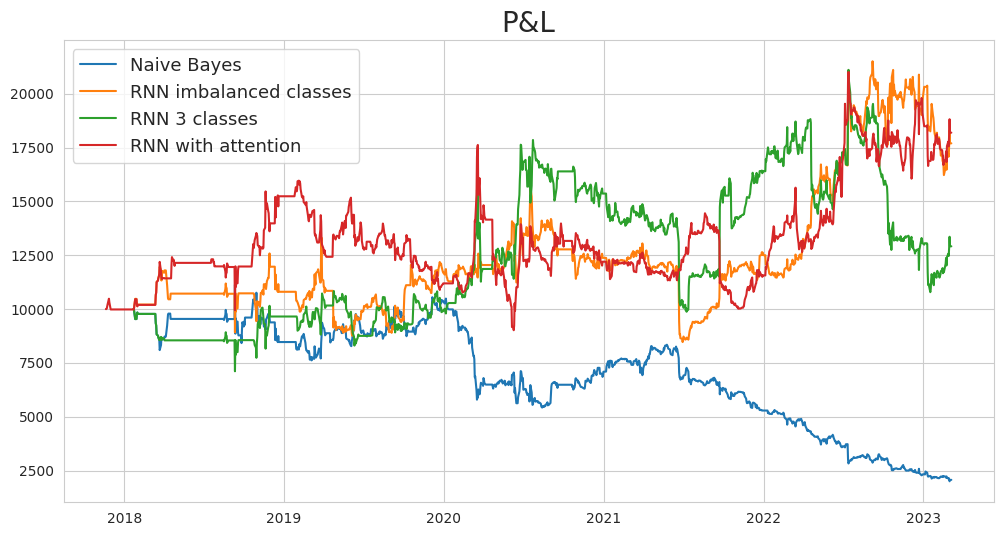

In [72]:
plt.figure(figsize=(12, 6))
plt.plot(pnl_v0['date'], pnl_v0['value'], label='Naive Bayes')
plt.plot(pnl_v1['date'], pnl_v1['value'], label='RNN imbalanced classes')
plt.plot(pnl_v2['date'], pnl_v2['value'], label='RNN 3 classes')
plt.plot(pnl_v3['date'], pnl_v3['value'], label='RNN with attention')
plt.title("P&L", fontsize=20)
plt.legend(fontsize=13)
plt.show()

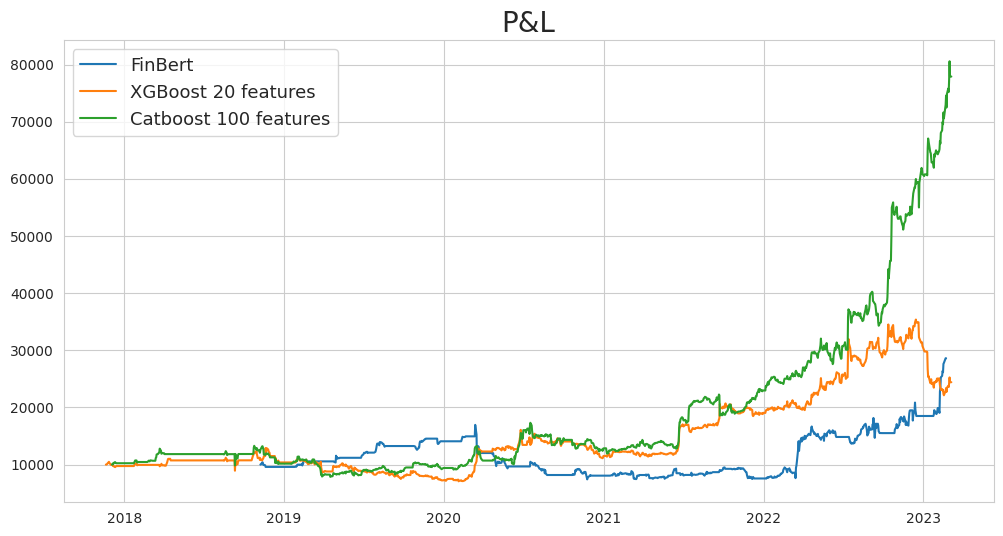

In [73]:
plt.figure(figsize=(12, 6))
plt.plot(pnl_v4['date'], pnl_v4['value'], label='FinBert')
plt.plot(pnl_v5['date'], pnl_v5['value'], label='XGBoost 20 features')
plt.plot(pnl_v6['date'], pnl_v6['value'], label='Catboost 100 features')
plt.title("P&L", fontsize=20)
plt.legend(fontsize=13)
plt.show()

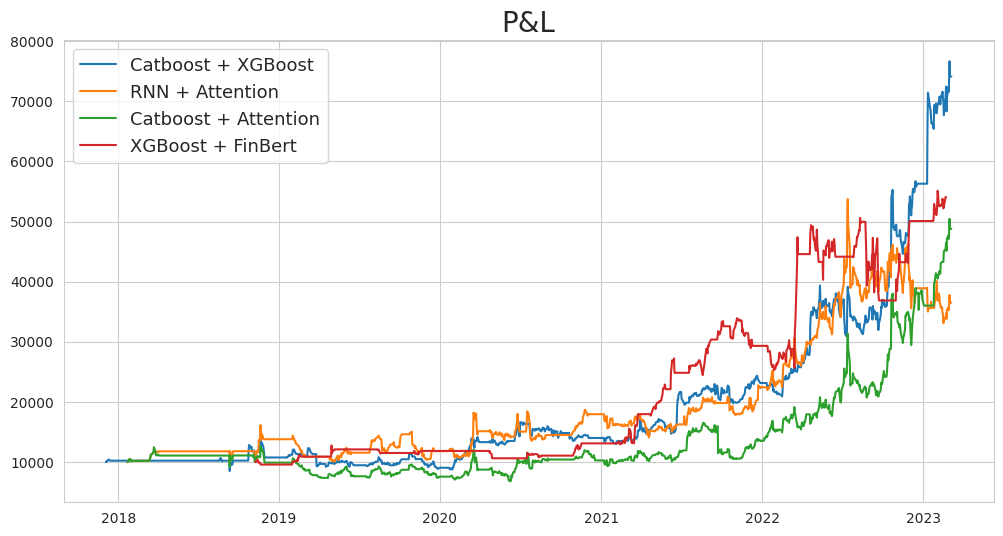

In [74]:
plt.figure(figsize=(12, 6))
plt.plot(pnl_v7['date'], pnl_v7['value'], label='Catboost + XGBoost')
plt.plot(pnl_v8['date'], pnl_v8['value'], label='RNN + Attention')
plt.plot(pnl_v9['date'], pnl_v9['value'], label='Catboost + Attention')
plt.plot(pnl_v10['date'], pnl_v10['value'], label='XGBoost + FinBert')
plt.title("P&L", fontsize=20)
plt.legend(fontsize=13)
plt.show()

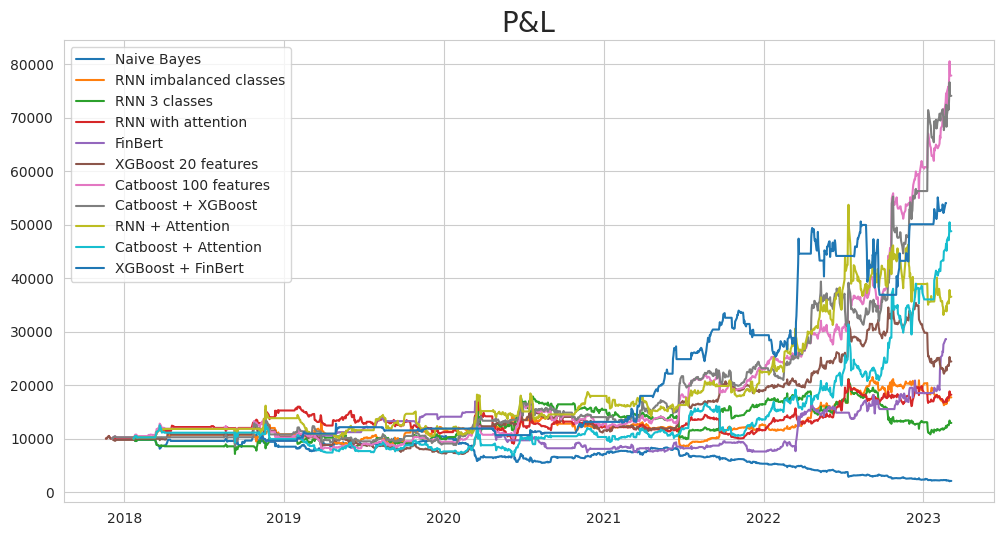

In [75]:
plt.figure(figsize=(12, 6))
plt.plot(pnl_v0['date'], pnl_v0['value'], label='Naive Bayes')
plt.plot(pnl_v1['date'], pnl_v1['value'], label='RNN imbalanced classes')
plt.plot(pnl_v2['date'], pnl_v2['value'], label='RNN 3 classes')
plt.plot(pnl_v3['date'], pnl_v3['value'], label='RNN with attention')
plt.plot(pnl_v4['date'], pnl_v4['value'], label='FinBert')
plt.plot(pnl_v5['date'], pnl_v5['value'], label='XGBoost 20 features')
plt.plot(pnl_v6['date'], pnl_v6['value'], label='Catboost 100 features')
plt.plot(pnl_v7['date'], pnl_v7['value'], label='Catboost + XGBoost')
plt.plot(pnl_v8['date'], pnl_v8['value'], label='RNN + Attention')
plt.plot(pnl_v9['date'], pnl_v9['value'], label='Catboost + Attention')
plt.plot(pnl_v10['date'], pnl_v10['value'], label='XGBoost + FinBert')
plt.title("P&L", fontsize=20)
plt.legend(fontsize=13)
plt.legend()
plt.show()

In [ ]:
pnl_v2.to_csv('/content/drive/MyDrive/ML_EPFL_Project/Strategies/v2.csv')

In [ ]:
pnl_v1.to_csv('/content/drive/MyDrive/ML_EPFL_Project/Strategies_stats/v1.csv')